In [1]:
import malariagen_data
import numpy as np
import dask
import dask.array as da
from dask.diagnostics.progress import ProgressBar
# silence some warnings
dask.config.set(**{'array.slicing.split_large_chunks': False})
import allel
import pandas as pd
import matplotlib.pyplot as plt
from re import sub
import seaborn as sns

Data access from Google Cloud is set up with the following code. 

In [2]:
ag3 = malariagen_data.Ag3(pre=True)

In [3]:
df_sample_sets = ag3.sample_sets(release="3.2")
df_sample_sets

,sample_set,sample_count,release
0,1177-VO-ML-LEHMANN-VMF00015,23,3.2
1,1237-VO-BJ-DJOGBENOU-VMF00050,90,3.2
2,1237-VO-BJ-DJOGBENOU-VMF00067,142,3.2
3,1244-VO-GH-YAWSON-VMF00051,666,3.2
4,1245-VO-CI-CONSTANT-VMF00054,38,3.2
5,1253-VO-TG-DJOGBENOU-VMF00052,179,3.2


In [4]:
meta = ag3.sample_metadata(
    sample_sets=["1244-VO-GH-YAWSON-VMF00051"]
)
meta.head()

Load sample metadata:   0%|          | 0/1 [00:00<?, ?it/s]

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,...,aim_species,country_iso,admin1_name,admin1_iso,admin2_name,taxon,cohort_admin1_year,cohort_admin1_month,cohort_admin2_year,cohort_admin2_month
0,VBS19051-5563STDY7800136,WA-0001,Alexander Egyir-Yawson,Ghana,Madina_North,2017,11,5.683,-0.166,F,...,gambiae,GHA,Greater Accra,GH-AA,Ga East,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_Ga-East_gamb_2017,GH-AA_Ga-East_gamb_2017_11
1,VBS19052-5563STDY7800137,WA-0002,Alexander Egyir-Yawson,Ghana,Madina_North,2017,11,5.683,-0.166,F,...,gambiae,GHA,Greater Accra,GH-AA,Ga East,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_Ga-East_gamb_2017,GH-AA_Ga-East_gamb_2017_11
2,VBS19053-5563STDY7800138,WA-0003,Alexander Egyir-Yawson,Ghana,Madina_North,2017,11,5.683,-0.166,F,...,gambiae,GHA,Greater Accra,GH-AA,Ga East,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_Ga-East_gamb_2017,GH-AA_Ga-East_gamb_2017_11
3,VBS19055-5563STDY7800140,WA-0005,Alexander Egyir-Yawson,Ghana,Madina_North,2017,11,5.683,-0.166,F,...,gambiae,GHA,Greater Accra,GH-AA,Ga East,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_Ga-East_gamb_2017,GH-AA_Ga-East_gamb_2017_11
4,VBS19056-5563STDY7800141,WA-0006,Alexander Egyir-Yawson,Ghana,Madina_North,2017,11,5.683,-0.166,F,...,gambiae,GHA,Greater Accra,GH-AA,Ga East,gambiae,GH-AA_gamb_2017,GH-AA_gamb_2017_11,GH-AA_Ga-East_gamb_2017,GH-AA_Ga-East_gamb_2017_11


In [5]:
meta.groupby(['country', 'location', 'year', 'taxon']).size()

country  location      year  taxon                        
Ghana    Korle-Bu      2018  coluzzii                         264
                             intermediate_gambiae_coluzzii      4
         Madina_North  2017  gambiae                          200
         Obuasi        2017  gambiae                          198
dtype: int64

In [6]:
sample_names = np.array(
    [sub('-.*', '', x) for x in meta.sample_id]
)
sample_names

array(['VBS19051', 'VBS19052', 'VBS19053', 'VBS19055', 'VBS19056',
       'VBS19057', 'VBS19058', 'VBS19059', 'VBS19060', 'VBS19062',
       'VBS19063', 'VBS19064', 'VBS19065', 'VBS19066', 'VBS19067',
       'VBS19068', 'VBS19070', 'VBS19071', 'VBS19074', 'VBS19075',
       'VBS19076', 'VBS19078', 'VBS19079', 'VBS19081', 'VBS19084',
       'VBS19086', 'VBS19087', 'VBS19088', 'VBS19091', 'VBS19093',
       'VBS19094', 'VBS19096', 'VBS19097', 'VBS19098', 'VBS19100',
       'VBS19101', 'VBS19102', 'VBS19103', 'VBS19104', 'VBS19105',
       'VBS19106', 'VBS19107', 'VBS19110', 'VBS19111', 'VBS19112',
       'VBS19114', 'VBS19116', 'VBS19121', 'VBS19123', 'VBS19124',
       'VBS19125', 'VBS19126', 'VBS19127', 'VBS19129', 'VBS19131',
       'VBS19132', 'VBS19133', 'VBS19134', 'VBS19135', 'VBS19136',
       'VBS19137', 'VBS19138', 'VBS19139', 'VBS19140', 'VBS19141',
       'VBS19142', 'VBS19143', 'VBS19144', 'VBS19145', 'VBS19149',
       'VBS19150', 'VBS19152', 'VBS19154', 'VBS19155', 'VBS191

In [7]:
# snp_differences is a 1-d array where each entry is the genetic difference at one locus. 
# The maximum possible difference at each locus is 2 (hom_alt vs hom_ref), so we divide by the number of 
# accessible sites * 2
def windowed_genetic_difference(snp_differences, pos, contig_size, window_size):
    pos_group = (pos - 1) // window_size
    max_window = (contig_size - 1) // window_size
    grouped_snp_differences = pd.DataFrame(snp_differences).groupby(pos_group.values)
    win_gen_diff = grouped_snp_differences.apply(lambda x: np.sum(x) / (len(x) * 2))
    # Any windows containing no SNPs will not be present in the data. Add those windows now with a difference
    # of 0
    missing_windows = np.array(list(set(range((contig_size - 1) // window_size)) - set(win_gen_diff.index)))
    add_df = pd.DataFrame([0]*len(missing_windows), index = missing_windows)
    full_win_gen_diff = win_gen_diff.append(add_df).sort_index()
    full_win_gen_diff.columns = ['gen_diff']
    return(full_win_gen_diff)

# Now look at homozygosity
def windowed_homozygosity(genotypes, pos, contig_size, window_size):
    pos_group = (pos - 1) // window_size
    max_window = (contig_size - 1) // window_size
    homozygosity = genotypes.is_hom()
    grouped_hom = pd.DataFrame(homozygosity).groupby(pos_group.values)
    win_hom = grouped_hom.apply(lambda x: np.sum(x, 0) / x.shape[0])
    win_hom.columns = ['hom1', 'hom2']
    return(win_hom)


In [8]:
# Function to calculate genetic difference and homozygosity along a chromosome for a given pair of samples
def genetic_difference_along_chrom(chrom, focal_samples, window_size):
    print(chrom)
    chrom_size = ag3.genome_sequence(chrom).shape[0]
    snp_calls = ag3.snp_calls(
        region = chrom,
        sample_sets = ['1244-VO-GH-YAWSON-VMF00051']
    )
    sample_names = np.array(
        [sub('-.*', '', x) for x in snp_calls.sample_id.values.astype('str')]
    )
    focal_sample_indices = np.where(np.isin(sample_names, focal_samples))[0]
    filter_pass = snp_calls.variant_filter_pass_gamb_colu
    focal_genotypes = allel.GenotypeArray(
        snp_calls.call_genotype[:, focal_sample_indices, :][filter_pass]
    )
    pos = snp_calls.variant_position[filter_pass]
    # Sequence divergence is not the best measure because it just gets the probability that two chromosomes picked 
    # at random, one from each individual, have different alleles. So if the individuals are each heterozygote at 
    # that site, they will have a divergence of 0.5 despite being identical. That's the same score that they would 
    # get if one was hom and the other het. So clones end up with a positive divergence.  
    # Let's just take the count of reference alleles and take the difference between the two individuals.
    snp_differences = np.absolute(
                                  np.diff(
                                          focal_genotypes.to_n_alt()
                                  )
    )
    windowed_differences = windowed_genetic_difference(snp_differences, pos, chrom_size, window_size)
    windowed_hom = windowed_homozygosity(focal_genotypes, pos, chrom_size, window_size)
    return(pd.concat([windowed_differences, windowed_hom], axis = 1))

In [9]:
chroms = ['2R', '2L', '3R', '3L', 'X']
window_size = 100000
pair1_samples = np.array(["VBS19078", "VBS19093"])
pair1 = {chrom: genetic_difference_along_chrom(chrom, pair1_samples, window_size) for chrom in chroms}

2R
2L
3R
3L
X


In [10]:
# Try another pair, from Korle-Bu
pair2_samples = np.array(["VBS19779", "VBS19968"])
pair2 = {chrom: genetic_difference_along_chrom(chrom, pair2_samples, window_size) for chrom in chroms}

2R
2L
3R
3L
X


In [11]:
# And an unrelated pair
pair3_samples = np.array(["VBS19051", "VBS19052"] )
pair3 = {chrom: genetic_difference_along_chrom(chrom, pair3_samples, window_size) for chrom in chroms}

2R
2L
3R
3L
X


In [12]:
chrom_sizes = {chrom: ag3.genome_sequence(chrom).shape[0] for chrom in chroms}
gaps = 5000000
chrom_ends_nogaps = np.cumsum(list(chrom_sizes.values()))
chrom_starts = chrom_ends_nogaps - np.array(list(chrom_sizes.values())) + np.array([0, 0, gaps, gaps, gaps*2])
chrom_starts = {chroms[i]: chrom_starts[i] for i in range(5)}
chrom_starts

{'2R': 0, '2L': 61545105, '3R': 115909430, '3L': 169110114, 'X': 216073549}

In [13]:
for chrom in pair1.keys():
    pair1[chrom]['chrom'] = chrom
    pair1[chrom]['genome_pos'] = pair1[chrom].index * window_size + chrom_starts[chrom]
    
pair1_table = pd.concat(list(pair1.values()))
pair1_table


,gen_diff,hom1,hom2,chrom,genome_pos
0,0.002048,0.996546,0.995777,2R,0
1,0.002750,0.995700,0.994394,2R,100000
2,0.004016,0.995155,0.994687,2R,200000
3,0.006333,0.991157,0.991901,2R,300000
4,0.007469,0.990202,0.990837,2R,400000
...,...,...,...,...,...
239,0.000199,0.997949,0.997916,X,239973549
240,0.000322,0.998005,0.998005,X,240073549
241,0.000122,0.996040,0.995867,X,240173549
242,0.000151,0.996748,0.996146,X,240273549


<AxesSubplot:xlabel='genome_pos', ylabel='gen_diff'>

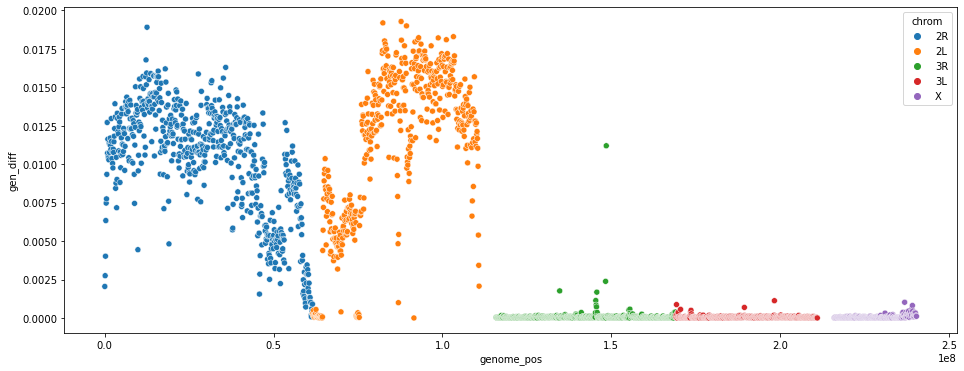

In [14]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair1_table.genome_pos, y = pair1_table.gen_diff, hue = pair1_table.chrom)

(0.95, 1.001)

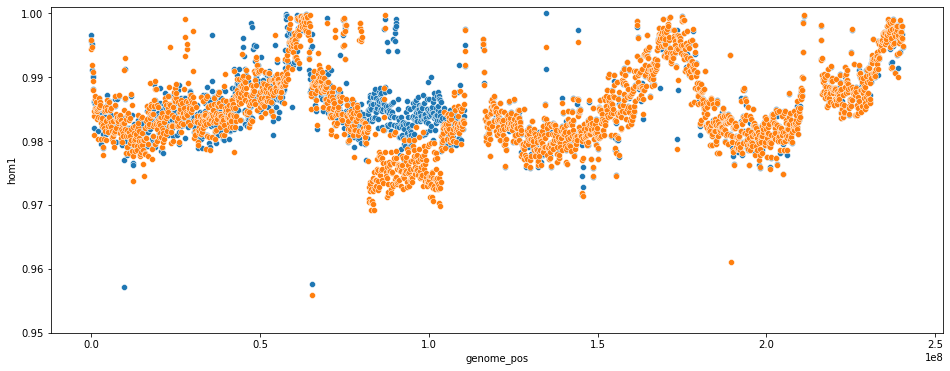

In [15]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair1_table.genome_pos, y = pair1_table.hom1)
sns.scatterplot(x = pair1_table.genome_pos, y = pair1_table.hom2)
plt.ylim(0.95, 1.001)

Text(0, 0.5, 'Genetic difference')

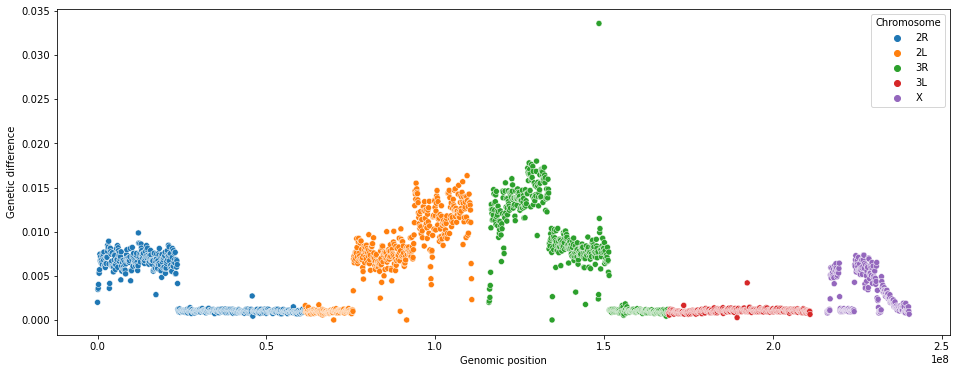

In [16]:
for chrom in pair2.keys():
    pair2[chrom]['Chromosome'] = chrom
    pair2[chrom]['genome_pos'] = pair2[chrom].index * window_size + chrom_starts[chrom]
    
pair2_table = pd.concat(list(pair2.values()))
plt.rcParams["figure.figsize"] = (16, 6)
p = sns.scatterplot(x = pair2_table.genome_pos, y = pair2_table.gen_diff, hue = pair2_table.Chromosome)
p.set_xlabel('Genomic position')
p.set_ylabel('Genetic difference')

In [17]:
# Save the figure
p.figure.savefig('genetic_difference_across_genome.png')

(0.95, 1.001)

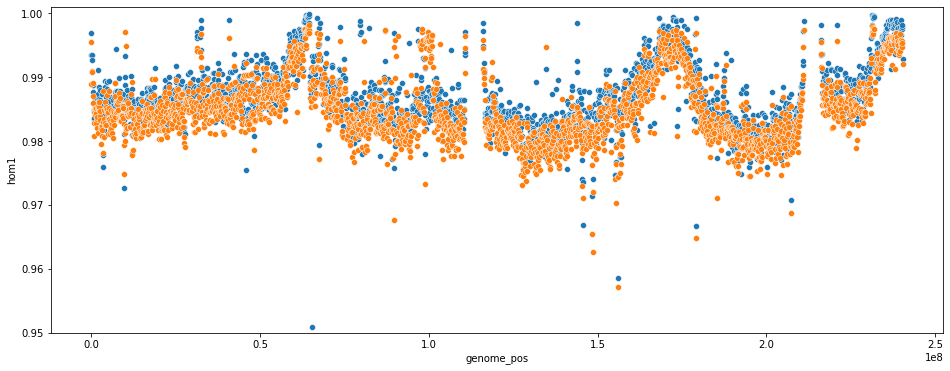

In [18]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair2_table.genome_pos, y = pair2_table.hom1)
sns.scatterplot(x = pair2_table.genome_pos, y = pair2_table.hom2)
plt.ylim(0.95, 1.001)

<AxesSubplot:xlabel='genome_pos', ylabel='gen_diff'>

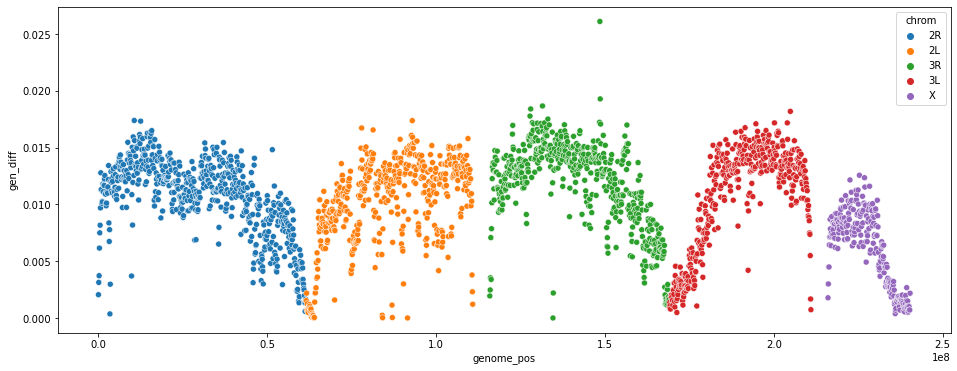

In [19]:
for chrom in pair3.keys():
    pair3[chrom]['chrom'] = chrom
    pair3[chrom]['genome_pos'] = pair3[chrom].index * window_size + chrom_starts[chrom]
    
pair3_table = pd.concat(list(pair3.values()))
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair3_table.genome_pos, y = pair3_table.gen_diff, hue = pair3_table.chrom)

(0.95, 1.001)

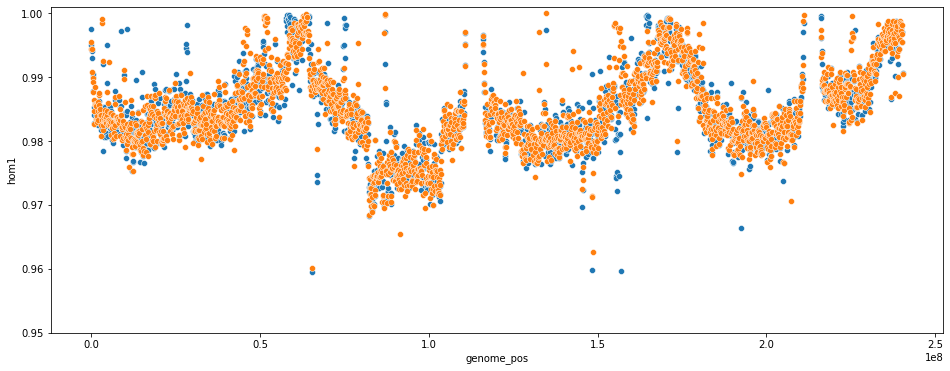

In [20]:
plt.rcParams["figure.figsize"] = (16, 6)
sns.scatterplot(x = pair3_table.genome_pos, y = pair3_table.hom1)
sns.scatterplot(x = pair3_table.genome_pos, y = pair3_table.hom2)
plt.ylim(0.95, 1.001)